✅ Input Data Shape: (283585, 40)
✅ Target Data Shape: (283585,)
🚀 Training des Modells...

📊 Model Evaluation:
🔹 Mean Squared Error (MSE): 151043.48
🔹 Mean Absolute Error (MAE): 259.27
🔹 R² Score: 0.64

🔥 Feature Importances:
gen_dispatchable_DE_TENNET       0.167690
load_DE_TENNET                   0.078022
load_DE_AMPRION                  0.042944
price_day_ahead_FR               0.041680
load_DE_TRANSNET                 0.040402
price_day_ahead_CH               0.040097
gen_run_off_hydro_DE_TENNET      0.038978
gen_dispatchable_DE_50HZ         0.034689
gen_run_off_hydro_DE_AMPRION     0.033050
gen_dispatchable_DE_AMPRION      0.032168
gen_wind_on_DE_50HZ              0.032072
gen_solar_DE_TENNET              0.029247
gen_wind_on_DE_TENNET            0.028764
gen_solar_DE_AMPRION             0.028647
price_day_ahead_DK_1             0.028637
gen_run_off_hydro_DE_TRANSNET    0.027884
gen_wind_total_DE_TENNET         0.022595
gen_wind_total_DE_50HZ           0.021334
price_day_ahead_PL

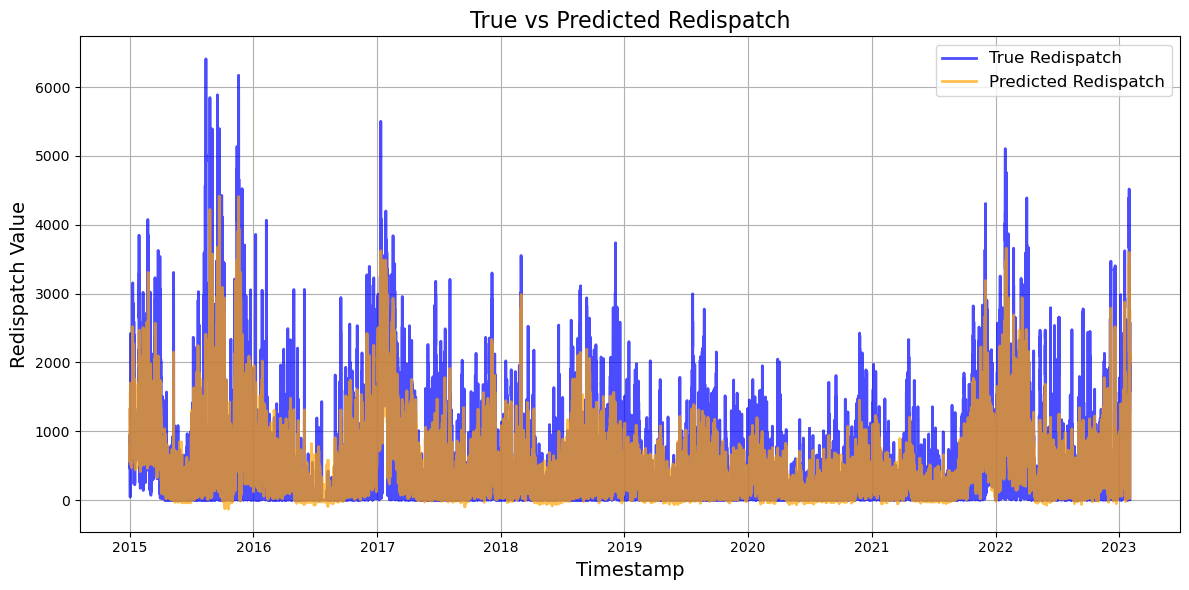

In [4]:
#XGBoost

import pickle
import pandas as pd
import os
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 🔹 Automatisch das aktuelle Verzeichnis bestimmen (Notebook oder Skript)
base_dir = Path().resolve()  # Ermittelt den aktuellen Arbeitsordner

# 🔹 Datenpfade RELATIV zum Projektordner setzen
data_dir = base_dir / "data"

input_data_path = data_dir / "aligned_input_data.pkl"
target_data_path = data_dir / "aligned_target_data.pkl"

# 🔹 Funktion zum Laden von Pickle-Dateien mit Fehlerbehandlung
def load_pickle(file_path):
    if not file_path.exists():
        raise FileNotFoundError(f"❌ Datei nicht gefunden: {file_path}")
    with open(file_path, "rb") as file:
        return pickle.load(file)

# ✅ Lade Daten
input_data = load_pickle(input_data_path)
target_data = load_pickle(target_data_path)

# 🔹 Sicherstellen, dass alle Spalten numerisch sind
input_data = input_data.apply(pd.to_numeric, errors="coerce")

# 🔹 Entferne doppelte Spalten
input_data = input_data.loc[:, ~input_data.columns.duplicated()]

# 🔹 Fehlende Werte behandeln
input_data = input_data.fillna(0)  # Ersetze NaN in input_data mit 0
target_data = target_data.fillna(target_data.mean())  # Ersetze NaN in target_data mit Durchschnitt

# 🔹 Indizes von input_data und target_data angleichen
input_data, target_data = input_data.align(target_data, join="inner", axis=0)

# 🔹 Form der Daten ausgeben
print(f"✅ Input Data Shape: {input_data.shape}")
print(f"✅ Target Data Shape: {target_data.shape}")

# 🔹 XGBoost-Modell erstellen & trainieren
model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

print("🚀 Training des Modells...")
model.fit(input_data, target_data)

# 🔹 Modell evaluieren
predictions = model.predict(input_data)
mse = mean_squared_error(target_data, predictions)
mae = mean_absolute_error(target_data, predictions)
r2 = r2_score(target_data, predictions)

print("\n📊 Model Evaluation:")
print(f"🔹 Mean Squared Error (MSE): {mse:.2f}")
print(f"🔹 Mean Absolute Error (MAE): {mae:.2f}")
print(f"🔹 R² Score: {r2:.2f}")

# 🔹 Feature Importance anzeigen
print("\n🔥 Feature Importances:")
feature_importances = pd.Series(model.feature_importances_, index=input_data.columns)
print(feature_importances.sort_values(ascending=False))

# 🔹 Visualisierung: Wahre vs. Vorhergesagte Werte
plt.figure(figsize=(12, 6))
plt.plot(target_data.index, target_data, label="True Redispatch", color="blue", alpha=0.7, linewidth=2)
plt.plot(target_data.index, predictions, label="Predicted Redispatch", color="orange", alpha=0.7, linewidth=2)

plt.title("True vs Predicted Redispatch", fontsize=16)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Redispatch Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


🚀 Training des Modells...


100%|===================| 283553/283585 [68:51<00:00]        

📊 Erstelle SHAP-Plots...


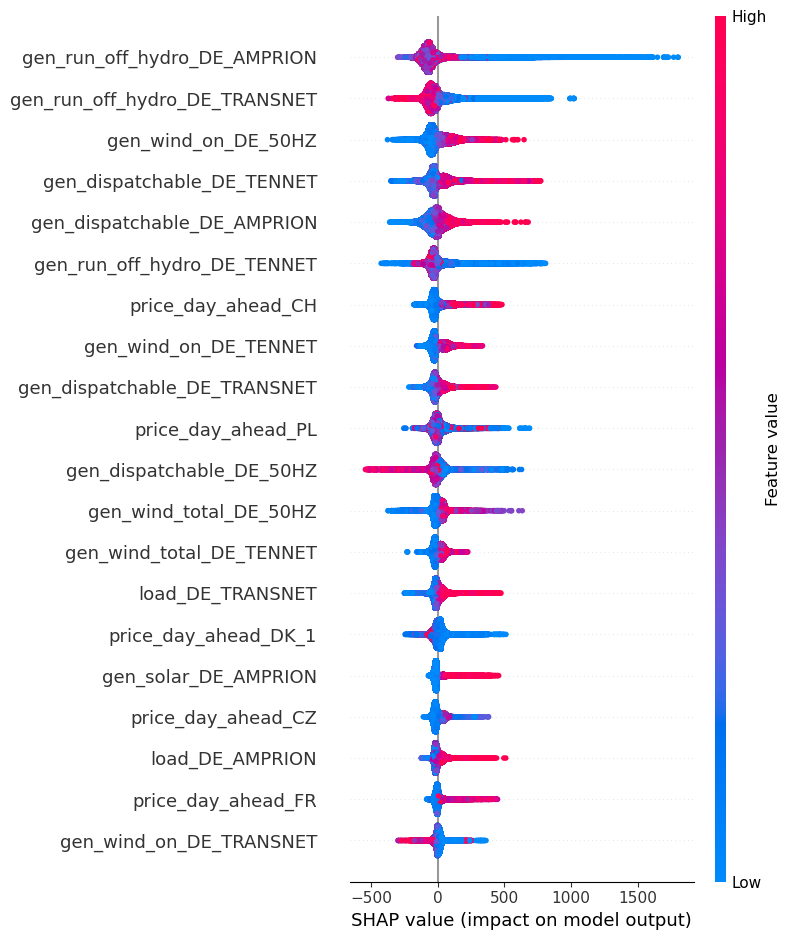

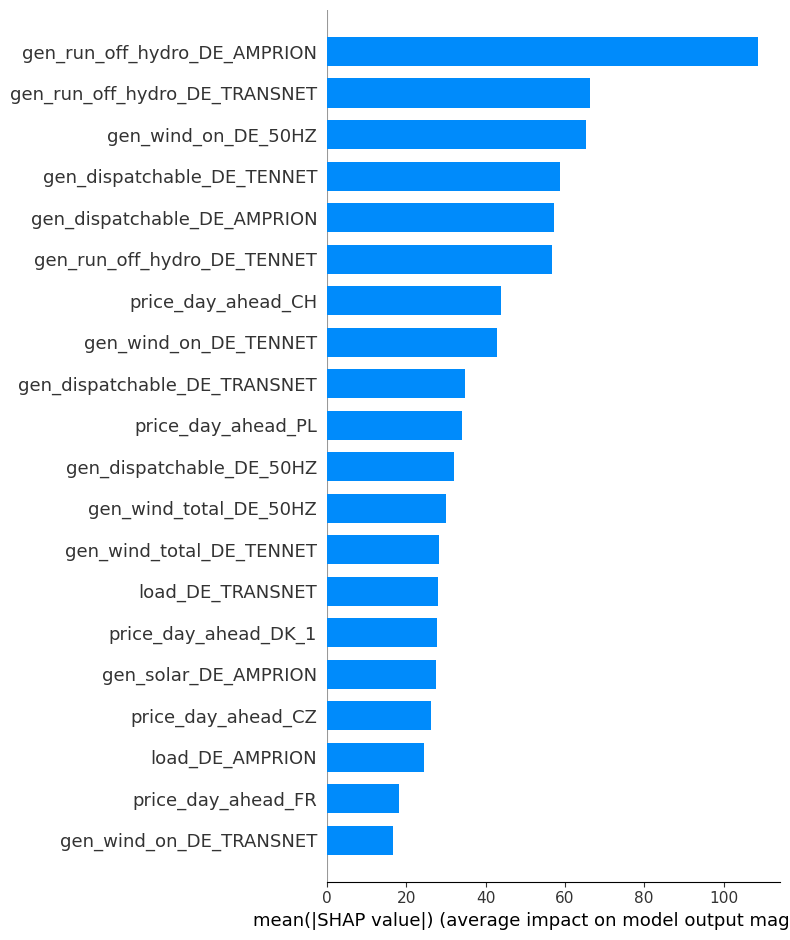

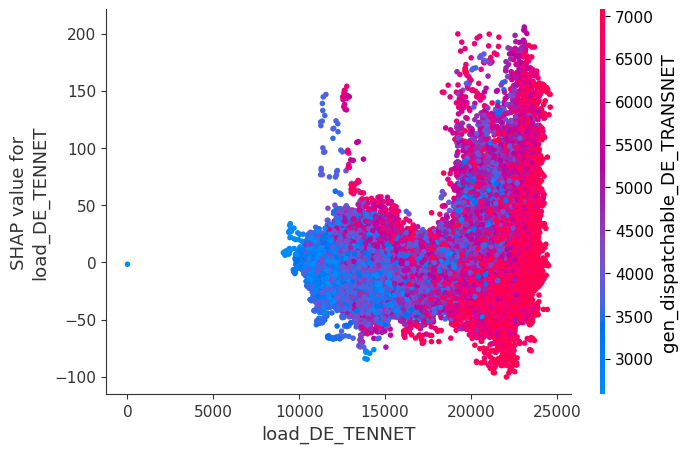

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [1]:
#SHAP


import shap
import xgboost as xgb
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

# 🔹 Automatisch das aktuelle Arbeitsverzeichnis bestimmen
base_dir = Path().resolve()  # Ermittelt den aktuellen Ordner (Notebook oder Skript)

# 🔹 Datenpfade relativ zum Projektordner setzen
data_dir = base_dir / "data"
input_data_path = data_dir / "aligned_input_data.pkl"
target_data_path = data_dir / "aligned_target_data.pkl"

# 🔹 Funktion zum Laden von Pickle-Dateien mit Fehlerprüfung
def load_pickle(file_path):
    if not file_path.exists():
        raise FileNotFoundError(f"❌ Datei nicht gefunden: {file_path}")
    with open(file_path, "rb") as file:
        return pd.read_pickle(file)

# ✅ Lade Daten
input_data = load_pickle(input_data_path)
target_data = load_pickle(target_data_path)

# 🔹 Fehlende Werte behandeln
input_data = input_data.fillna(0)
target_data = target_data.fillna(target_data.mean())

# 🔹 Trainiere das XGBoost-Modell
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)

print("🚀 Training des Modells...")
model.fit(input_data, target_data)

# 🔹 Erstelle SHAP-Explainer
explainer = shap.Explainer(model, input_data)

# 🔹 Berechne SHAP-Werte
shap_values = explainer(input_data)

# 🔹 SHAP Visualisierungen
print("📊 Erstelle SHAP-Plots...")

# 1️⃣ Summary Plot
shap.summary_plot(shap_values, input_data)

# 2️⃣ Bar Plot für Feature-Importance
shap.summary_plot(shap_values, input_data, plot_type="bar")

# 3️⃣ Dependence Plot für eine spezifische Feature-Spalte (falls vorhanden)
feature_name = "load_DE_TENNET"  # Anpassbar an deinen Datensatz
if feature_name in input_data.columns:
    shap.dependence_plot(feature_name, shap_values.values, input_data)

# 4️⃣ Force Plot für eine einzelne Instanz
shap.initjs()  # Aktiviert JS-Rendering in Jupyter Notebook
display(shap.force_plot(explainer.expected_value, shap_values[0, :], input_data.iloc[0, :]))

print("✅ SHAP-Analyse abgeschlossen!")
